# Analise de Sentimentos

Será desenvolvido um modelo com o objetivo de predizer se o review de um produto é Bom ou Ruim.
Serão utilizados três datasets (Amazon, IMDB, Yelp).

Importando pacotes necessários

In [147]:
import pandas as pd
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
import nltk
from nltk import SnowballStemmer
import matplotlib.pyplot as plt
import itertools
import numpy as np
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
%matplotlib inline

In [148]:
import os
print(os.listdir("../input/"))

['readme.txt', 'amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']


## Tarefas
### 1. Lendo dados e concatenando datasets
    Os datasets são lidos e concatenados, além disso uma coluna de origem é criada para posterior análise descritiva sobre a diferença das bases

In [149]:
files = {'amazon': '../input/amazon_cells_labelled.txt', 'imdb': '../input/imdb_labelled.txt', 'yelp': '../input/yelp_labelled.txt'}
df = pd.DataFrame()
for f in files.keys():
    df1 = pd.read_csv(files[f], sep='\t', names=['text','label'])
    df1['origin'] = f
    df = pd.concat([df, df1])

In [150]:
df['origin'].value_counts()

amazon    1000
yelp      1000
imdb       748
Name: origin, dtype: int64

In [151]:
pd.crosstab(df['origin'],df['label'])

label,0,1
origin,,
amazon,500,500
imdb,362,386
yelp,500,500


### 2. Limpeza e preparação dos dados
Por se tratar de dados textuais, antes de iniciar qualquer análise é necessário fazer uma limpeza dos textos retirando números, acentos e caracteres especiais. 
Além disso, as três etapas principais para a preparação dos dados de texto são:

* Tokenizar: Separar em palavras;

* Retirar stopwords: palavras de conexão, sem significado adicional

* Stemming: Reduzir palavras em sua raiz. Ex: [trocar, troco, trocas] → troc 


In [152]:
def pre_processing(text):
    # remove pontuacao e caracteres especiais
    text = text.lower()
    punctuation = re.compile('[%s]' % re.escape('!"#$%&\'()*´,-./:;<=>?@[\\]^_`{|}~|0123456789'))
    text = punctuation.sub('', text)
    # tokeniza palavras
    tokens = nltk.word_tokenize(text)
    # retira stopwords
    stops = set(stopwords.words("english"))
    tokens = [w for w in tokens if (not w in stops)]
    # realiza o stemming
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(t) for t in tokens]
    return tokens

In [153]:
df['text_vec'] = df['text'].apply(lambda x: pre_processing(x))

### 3. Análise descritiva
Serão criadas apenas wordclouds para uma análise visual das frequências das palavras

In [154]:
def analyze_words(df):
    print('Vectorize')
    counts = Counter(list(itertools.chain.from_iterable(df['text_vec'].values)))
    print('WordCloud')
    plt.figure(figsize=[15,30])
    wordcloud = WordCloud(max_words=1000, background_color='white', relative_scaling=.1, width=1200,
                          height=600).generate_from_frequencies(counts)
    wordcloud.to_file('wordcloud.jpg')
    plt.imshow(wordcloud)
    plt.show()

Palavras mais frequentes no geral

Vectorize
WordCloud


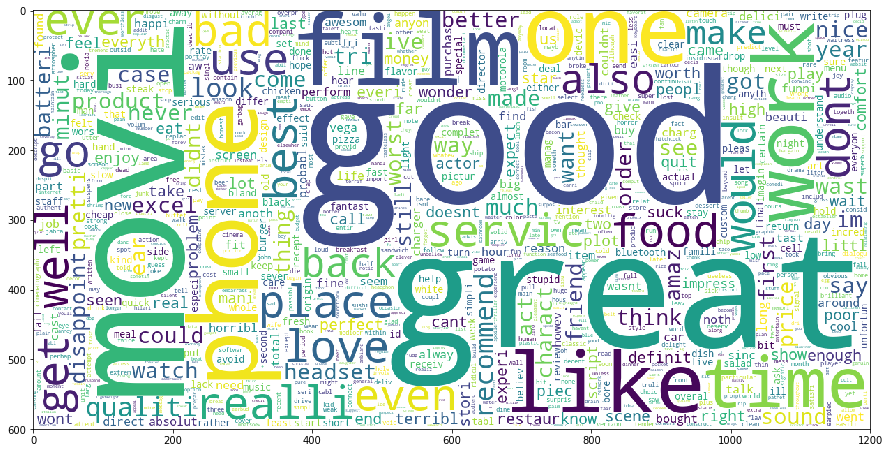

In [155]:
analyze_words(df)

É possível perceber que palavras como Great e Good aparecem em destaque, mostrando que as reviews positivas podem estar mais claras e fáceis de identificar.  Também é possível enxergar algumas negativas como disappoint e bad. Vamos visualizar se essas palavras ficam realmente separadas de acordo com a label:

**WordCloud de reviews positivas**

Vectorize
WordCloud


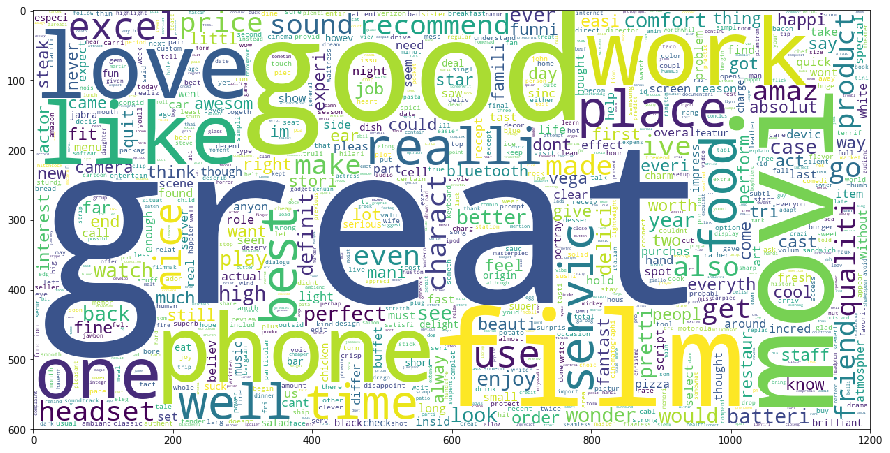

In [156]:
analyze_words(df[df['label']==1])

As palavras negativas vistas anteriormente (bad, disappoint) já não aparecem aqui

**WordCloud de Reviews Negativas**

Vectorize
WordCloud


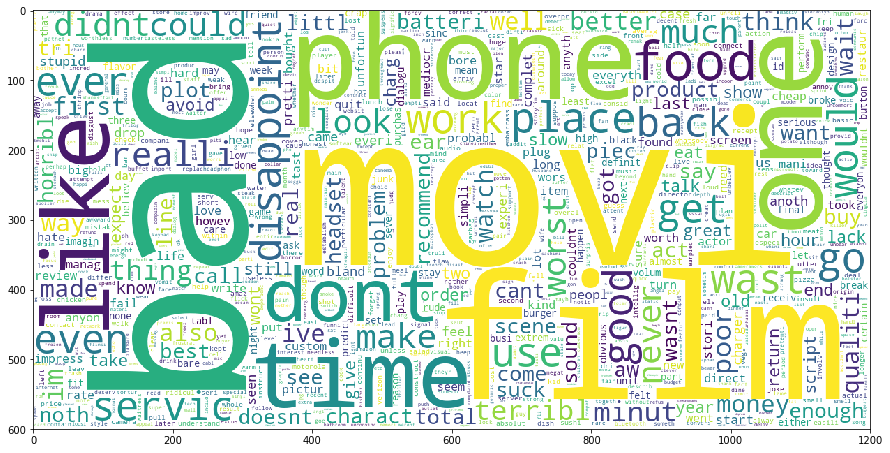

In [157]:
analyze_words(df[df['label']==0])

As palavras positivas vistas anteriormente (great, good) já não aparecem aqui.

Por fim, a título de curiosidade, vamos ver se há diferença entre as palavras de acordo com a origem do DataSet

Amazon
-----
Vectorize
WordCloud


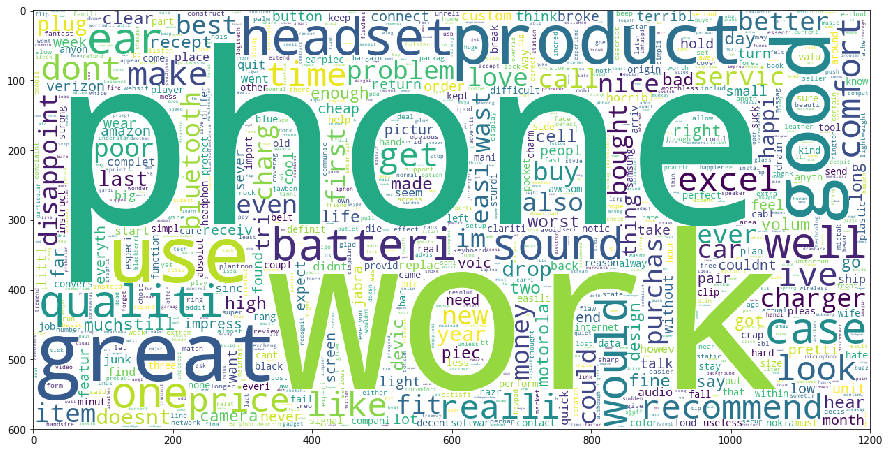

IMDB
-----
Vectorize
WordCloud


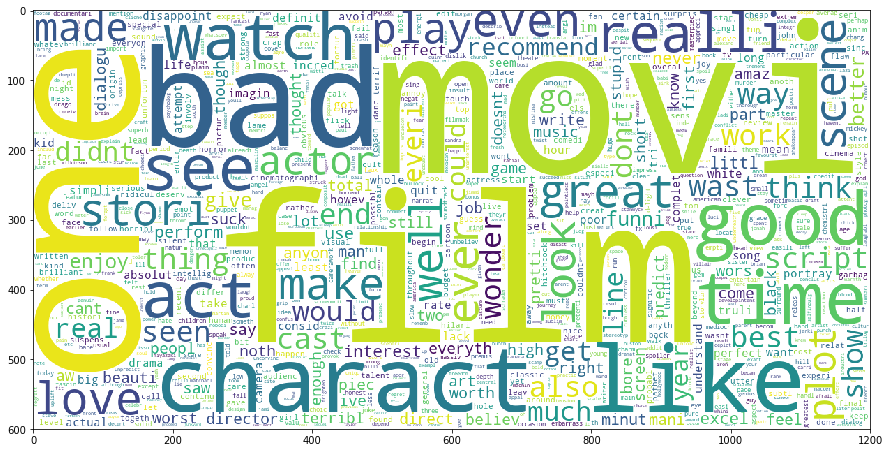

Yelp
-----
Vectorize
WordCloud


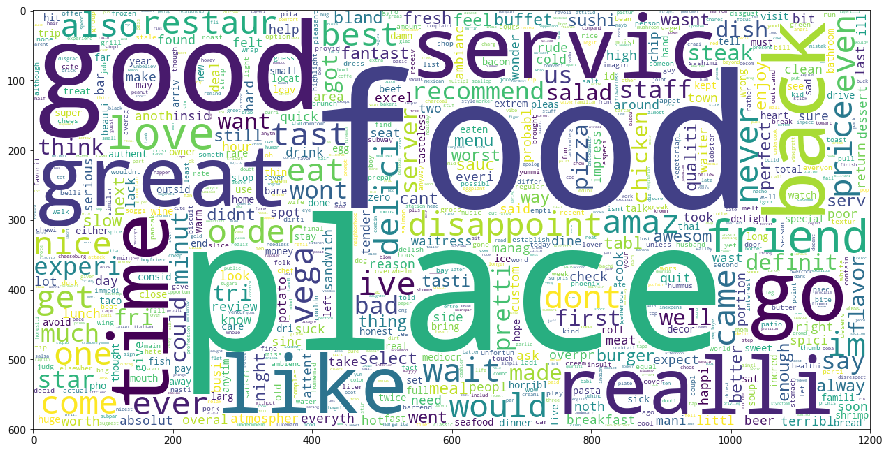

In [158]:
# WordCloud Amazon
print("Amazon")
print("-----")
analyze_words(df[df['origin']=='amazon'])

print("IMDB")
print("-----")
analyze_words(df[df['origin']=='imdb'])

print("Yelp")
print("-----")
analyze_words(df[df['origin']=='yelp'])


Podemos ver que a Amazon tem muitos reviews de Celulares e Headsets, a IMDB reviews de Filmes e a Yelp de lugares principalmente com comida

### 4. Feature Engineering
É necessário criar o vetor de palavras que será utilizado como entrada para o modelo. Existem alguns métodos existentes para realizar essa tarefa, sendo possível utilizar as próprias frequências das palavras, seja com o Count ou o TF-IDF. Aqui porém utilizaremos o método de word2vec, que leva em conta o contexto, utiliza redes neurais para criar vetores de tal forma que palavras com o mesmo contexto fiquem próximas. 

In [159]:
# metodo pra calcular a media do vetor para as palavras da frase
def calcula_vetor(text, vector_model, n_vec):
    vetor = np.zeros(n_vec)
    for t in text:
        try:
            vetor = vetor + vector_model[t]
        except:
            pass
    vetor = vetor/len(text)
    return vetor
        

In [241]:
text = df['text_vec'].values
# tamanho do vetor de palavras padrão é 100, o que pode ser mudado passando o parâmetro size
n_vec = 150
text_vector = Word2Vec(text, size = n_vec)
X = [calcula_vetor(t, text_vector, n_vec) for t in text]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [242]:
print(len(X))
print(X[0])
X = pd.DataFrame(X)
X = X.replace([-np.inf, np.inf], np.nan).fillna(0)
Y = df['label']

2748
[-1.26920332e-02  1.10181281e-03  2.04583560e-02 -2.66657178e-02
 -5.28075992e-02 -2.36846026e-04  1.92492480e-02  1.36025408e-02
  1.20710490e-02 -5.47460040e-03 -1.85699631e-02  1.98763714e-02
 -4.63896096e-03 -3.84066437e-02 -1.18271877e-02 -2.31251166e-02
 -2.24551195e-02 -1.26129706e-02  1.62390615e-02 -9.08808224e-03
  1.62244366e-02  1.95547023e-02  9.45901395e-03  5.84243865e-04
  2.96520162e-02 -1.56682442e-02  1.87986766e-02 -8.90601399e-03
 -2.22765953e-03 -1.45756263e-02 -1.30432212e-02 -4.52950856e-02
  3.81816925e-02  1.29061221e-02 -1.41932293e-03 -4.24448335e-03
 -1.12932535e-02  1.69923709e-02 -3.09472294e-03  5.74008212e-03
  2.94494257e-02  6.01071316e-02  3.54686494e-02  4.20155821e-03
  4.45964480e-03 -4.81027885e-02 -2.64741771e-04  8.12584841e-03
 -7.64364947e-03  3.24214893e-02  4.42298579e-03 -1.89537440e-02
 -1.93358152e-02 -4.21786591e-02 -2.62529502e-02  2.13631464e-02
  9.84819695e-03 -2.14504052e-02  5.96791684e-03  1.90216952e-02
 -5.40968391e-02  8.


### 4. Treinamento.

Será utilizado o método Random Forest, muito eficiente na maior parte dos problemas, não precisando de muita parametrização

In [243]:
#Separando 20% dos dados para validação
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=0)

In [244]:
model_class = RandomForestClassifier(n_estimators=300, random_state=20)
model_class = model_class.fit(X_train, y_train)

### 4. Validação

In [245]:
y_pred = model_class.predict_proba(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred[:, 1])
roc = pd.DataFrame(
    {'tf': pd.Series(tpr - (1 - fpr)), 'threshold': pd.Series(threshold), 'tpr': tpr,
     'fpr': fpr})
roc_t = roc.ix[(roc.tf - 0).abs().argsort()[:1]]
print(roc_t)
print(metrics.auc(fpr, tpr))

          fpr       tf  threshold       tpr
109  0.348754  0.00303   0.506667  0.654275
0.7046197198005001


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Text(0,0.5,'True Positive Rate')

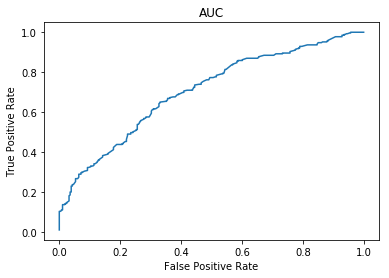

In [246]:
plt.plot(fpr,tpr)
plt.title('AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

0.7 de AUC é um resultado inicial bom, com Treshold de 0.5 (melhor encontrado da curva), são obtidos TPR de 0.63 e FPR de 0.35
Para melhorar esses resultados podem ser testados outras formas de criar o vetor de palavras, como o TF-IDF e outros algoritmo de ML, como o XGBoost, SVM, Regressão Logística, etc.